In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from collections import Counter
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

from sqlalchemy import create_engine
import psycopg2
import datetime

### Read data from csv

In [70]:
# Read indexProcessed.csv
df = pd.read_csv('Data/indexProcessed.csv')
df.dtypes

Index         object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
CloseUSD     float64
dtype: object

In [71]:
# Read indexInfo.csv
df_ref = pd.read_csv('Data/indexInfo.csv')
df_ref.dtypes

Region      object
Exchange    object
Index       object
Currency    object
dtype: object

In [72]:
# Merged DF 
Merged_df = pd.merge(df_ref,df, how='inner')
Merged_df.head(3)

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,United States,New York Stock Exchange,NYA,USD,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0,528.690002
1,United States,New York Stock Exchange,NYA,USD,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0,527.210022
2,United States,New York Stock Exchange,NYA,USD,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0,527.840027


### DF for NYA

In [73]:
# Dataframe for NYA

df_NYA = Merged_df[Merged_df['Index'] == 'NYA']
df_NYA.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,United States,New York Stock Exchange,NYA,USD,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0,528.690002
1,United States,New York Stock Exchange,NYA,USD,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0,527.210022
2,United States,New York Stock Exchange,NYA,USD,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0,527.840027
3,United States,New York Stock Exchange,NYA,USD,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0,531.119995
4,United States,New York Stock Exchange,NYA,USD,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0,532.070007


### Update Date datatype

In [74]:
df_NYA["Date"] = pd.to_datetime(df_NYA["Date"])
df_NYA.dtypes

/Users/michalmichael/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Region               object
Exchange             object
Index                object
Currency             object
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
CloseUSD            float64
dtype: object

### add prev day close, high, low to todays row

In [75]:
for i in range(1, len(df_NYA)):
    df_NYA.loc[i,'PrevClose'] = df_NYA.loc[i-1,'Close']
    df_NYA.loc[i,'PrevHigh'] = df_NYA.loc[i-1,'High']
    df_NYA.loc[i,'PrevLow'] = df_NYA.loc[i-1,'Low']
    
df_NYA.head()

/Users/michalmichael/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/michalmichael/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow
0,United States,New York Stock Exchange,NYA,USD,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0,528.690002,NaN,NaN,NaN
1,United States,New York Stock Exchange,NYA,USD,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0,527.210022,528.690002,528.690002,528.690002
2,United States,New York Stock Exchange,NYA,USD,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0,527.840027,527.210022,527.210022,527.210022
3,United States,New York Stock Exchange,NYA,USD,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0,531.119995,527.840027,527.840027,527.840027
4,United States,New York Stock Exchange,NYA,USD,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0,532.070007,531.119995,531.119995,531.119995


### create target

In [76]:
# Find delta of today's close price from yesterday's close price 

df_NYA['Delta'] = df_NYA['Close'].diff(periods=1)
df_NYA.head()

/Users/michalmichael/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta
0,United States,New York Stock Exchange,NYA,USD,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0,528.690002,NaN,NaN,NaN,NaN
1,United States,New York Stock Exchange,NYA,USD,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0,527.210022,528.690002,528.690002,528.690002,-1.479980
2,United States,New York Stock Exchange,NYA,USD,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0,527.840027,527.210022,527.210022,527.210022,0.630005
3,United States,New York Stock Exchange,NYA,USD,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0,531.119995,527.840027,527.840027,527.840027,3.279968
4,United States,New York Stock Exchange,NYA,USD,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0,532.070007,531.119995,531.119995,531.119995,0.950012


In [77]:
#  Add traget column to dataframe

df_NYA['Target'] = np.where(df_NYA['Delta']>=0, 'Up', 'Down')
df_NYA.head()

/Users/michalmichael/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Target
0,United States,New York Stock Exchange,NYA,USD,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0,528.690002,NaN,NaN,NaN,NaN,Down
1,United States,New York Stock Exchange,NYA,USD,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0,527.210022,528.690002,528.690002,528.690002,-1.479980,Down
2,United States,New York Stock Exchange,NYA,USD,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0,527.840027,527.210022,527.210022,527.210022,0.630005,Up
3,United States,New York Stock Exchange,NYA,USD,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0,531.119995,527.840027,527.840027,527.840027,3.279968,Up
4,United States,New York Stock Exchange,NYA,USD,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0,532.070007,531.119995,531.119995,531.119995,0.950012,Up


In [78]:
# drop NaN
df_NYA = df_NYA.dropna(how="any")
df_NYA.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Target
1,United States,New York Stock Exchange,NYA,USD,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0,527.210022,528.690002,528.690002,528.690002,-1.479980,Down
2,United States,New York Stock Exchange,NYA,USD,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0,527.840027,527.210022,527.210022,527.210022,0.630005,Up
3,United States,New York Stock Exchange,NYA,USD,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0,531.119995,527.840027,527.840027,527.840027,3.279968,Up
4,United States,New York Stock Exchange,NYA,USD,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0,532.070007,531.119995,531.119995,531.119995,0.950012,Up
5,United States,New York Stock Exchange,NYA,USD,1966-01-07,532.599976,532.599976,532.599976,532.599976,532.599976,0.0,532.599976,532.070007,532.070007,532.070007,0.529969,Up


In [79]:
df_NYA.isnull().sum()

Region       0
Exchange     0
Index        0
Currency     0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
CloseUSD     0
PrevClose    0
PrevHigh     0
PrevLow      0
Delta        0
Target       0
dtype: int64

In [80]:
list(df_NYA)

['Region',
 'Exchange',
 'Index',
 'Currency',
 'Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'CloseUSD',
 'PrevClose',
 'PrevHigh',
 'PrevLow',
 'Delta',
 'Target']

### logistic regression

In [81]:
from sklearn.linear_model import LogisticRegression

y = df_NYA['Target']
X = df_NYA[['Open',
 'PrevHigh',
 'PrevLow',
 'PrevClose'
           ]]

clf = LogisticRegression(random_state=0).fit(X, y)
clf.predict(X)

clf.predict_proba(X)

clf.score(X, y)

0.8460490463215259

### split data into training and testing

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, = train_test_split (X,
                                                     y,
                                                     random_state =1,
                                                     stratify = y)

X_train.shape
Counter(y_train)

Counter({'Up': 5580, 'Down': 4879})

### random forest classifier

In [83]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Create a random forest classifier.
model = BalancedRandomForestClassifier(n_estimators=100, random_state=1) 

# Fitting the model
model = model.fit(X_train, y_train)

In [84]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.7708172241277897

In [85]:
len(y_pred)

3487

In [86]:
# create an acutal and predicted df
RFC_pred_df = pd.DataFrame({"Prediction": y_pred, "Actual": y_test})
RFC_pred_df.head()

,Prediction,Actual
5403,Up,Up
1746,Down,Down
8985,Down,Down
4186,Up,Up
13791,Down,Down


In [87]:
# merge test predictions with intitial df for comparison
RFC_df = RFC_pred_df.merge(df_NYA, left_index=True, right_index=True)
RFC_df = RFC_df[['Region', 'Exchange', 'Index', 'Currency',
       'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'CloseUSD', 'PrevClose', 'PrevHigh', 'PrevLow', 'Delta', 'Target', 'Actual','Prediction']]
RFC_df.drop('Target', axis=1, inplace=True)
RFC_df['Date'] =  pd.to_datetime(RFC_df['Date'])
RFC_df.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Actual,Prediction
5403,United States,New York Stock Exchange,NYA,USD,1987-07-07,1828.089966,1828.089966,1828.089966,1828.089966,1828.089966,0.000000e+00,1828.089966,1813.920044,1813.920044,1813.920044,14.169922,Up,Up
1746,United States,New York Stock Exchange,NYA,USD,1973-01-15,681.159973,681.159973,681.159973,681.159973,681.159973,0.000000e+00,681.159973,686.760010,686.760010,686.760010,-5.600037,Down,Down
8985,United States,New York Stock Exchange,NYA,USD,2001-09-07,5986.529785,5986.529785,5986.529785,5986.529785,5986.529785,1.424300e+09,5986.529785,6104.319824,6104.319824,6104.319824,-117.790039,Down,Down
4186,United States,New York Stock Exchange,NYA,USD,1982-09-13,740.479980,740.479980,740.479980,740.479980,740.479980,0.000000e+00,740.479980,733.919983,733.919983,733.919983,6.559997,Up,Up
13791,United States,New York Stock Exchange,NYA,USD,2020-10-15,12974.129880,13148.700200,12960.980470,13137.250000,13137.250000,3.717640e+09,13137.250000,13143.160160,13267.160160,13135.900390,-5.910160,Down,Down


In [88]:
# export as csv
RFC_df.to_csv('Data/data_2/Random_Forest_Predictions_2.csv')

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
RFC_plot_df = RFC_df
RFC_plot_df['Encoded'] = RFC_plot_df['Prediction'].map({'Up':1, 'Down':0})
RFC_plot_df.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Actual,Prediction,Encoded
5403,United States,New York Stock Exchange,NYA,USD,1987-07-07,1828.089966,1828.089966,1828.089966,1828.089966,1828.089966,0.000000e+00,1828.089966,1813.920044,1813.920044,1813.920044,14.169922,Up,Up,1
1746,United States,New York Stock Exchange,NYA,USD,1973-01-15,681.159973,681.159973,681.159973,681.159973,681.159973,0.000000e+00,681.159973,686.760010,686.760010,686.760010,-5.600037,Down,Down,0
8985,United States,New York Stock Exchange,NYA,USD,2001-09-07,5986.529785,5986.529785,5986.529785,5986.529785,5986.529785,1.424300e+09,5986.529785,6104.319824,6104.319824,6104.319824,-117.790039,Down,Down,0
4186,United States,New York Stock Exchange,NYA,USD,1982-09-13,740.479980,740.479980,740.479980,740.479980,740.479980,0.000000e+00,740.479980,733.919983,733.919983,733.919983,6.559997,Up,Up,1
13791,United States,New York Stock Exchange,NYA,USD,2020-10-15,12974.129880,13148.700200,12960.980470,13137.250000,13137.250000,3.717640e+09,13137.250000,13143.160160,13267.160160,13135.900390,-5.910160,Down,Down,0


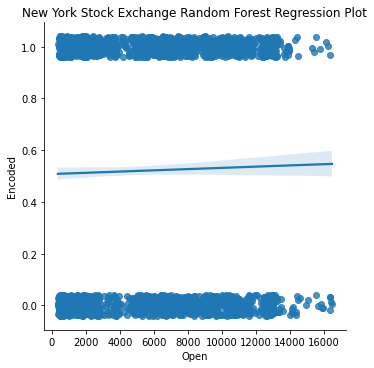

In [91]:
RFC_reg_plot = sns.lmplot(x="Open", y="Encoded", data=RFC_plot_df,
           logistic=True, y_jitter=.04);
RFC_reg_plot.set(title = 'New York Stock Exchange Random Forest Regression Plot')

In [92]:
RFC_reg_plot.savefig('Plots/plots_2/NYA_Random_Forest_Regression_2.png')

In [93]:
# Display the confusion matrix
#from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, y_pred)

array([[1253,  374],
       [ 425, 1435]])

In [94]:
# Print the imbalanced classification report
#from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Down       0.75      0.77      0.77      0.76      0.77      0.59      1627
         Up       0.79      0.77      0.77      0.78      0.77      0.59      1860

avg / total       0.77      0.77      0.77      0.77      0.77      0.59      3487



In [95]:
# List the features sorted in descending order by feature importance
sorted(zip(model.feature_importances_,X.columns), reverse=True)

[(0.401947919478285, 'Open'),
 (0.20375176885031077, 'PrevClose'),
 (0.19781243646702953, 'PrevHigh'),
 (0.19648787520437458, 'PrevLow')]

### SMOTE

In [96]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample( X_train, y_train)

In [97]:
Counter(y_resampled)

Counter({'Up': 5580, 'Down': 5580})

In [98]:
# Train the Logistic Regression model using the resampled data
#from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [99]:
# Calculated the balanced accuracy score
#from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.8715559344660996

In [100]:
# create an acutal and predicted df
SRFC_pred_df = pd.DataFrame({"Prediction": y_pred, "Actual": y_test})
SRFC_pred_df.head()

,Prediction,Actual
5403,Up,Up
1746,Down,Down
8985,Down,Down
4186,Up,Up
13791,Down,Down


In [101]:
# merge test predictions with intitial df for comparison
SRFC_df = SRFC_pred_df.merge(df_NYA, left_index=True, right_index=True)
SRFC_df = SRFC_df[['Region', 'Exchange', 'Index', 'Currency',
       'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'CloseUSD', 'PrevClose', 'PrevHigh', 'PrevLow', 'Delta', 'Target', 'Actual','Prediction']]
SRFC_df.drop('Target', axis=1, inplace=True)
SRFC_df['Date'] =  pd.to_datetime(SRFC_df['Date'])
SRFC_df.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Actual,Prediction
5403,United States,New York Stock Exchange,NYA,USD,1987-07-07,1828.089966,1828.089966,1828.089966,1828.089966,1828.089966,0.000000e+00,1828.089966,1813.920044,1813.920044,1813.920044,14.169922,Up,Up
1746,United States,New York Stock Exchange,NYA,USD,1973-01-15,681.159973,681.159973,681.159973,681.159973,681.159973,0.000000e+00,681.159973,686.760010,686.760010,686.760010,-5.600037,Down,Down
8985,United States,New York Stock Exchange,NYA,USD,2001-09-07,5986.529785,5986.529785,5986.529785,5986.529785,5986.529785,1.424300e+09,5986.529785,6104.319824,6104.319824,6104.319824,-117.790039,Down,Down
4186,United States,New York Stock Exchange,NYA,USD,1982-09-13,740.479980,740.479980,740.479980,740.479980,740.479980,0.000000e+00,740.479980,733.919983,733.919983,733.919983,6.559997,Up,Up
13791,United States,New York Stock Exchange,NYA,USD,2020-10-15,12974.129880,13148.700200,12960.980470,13137.250000,13137.250000,3.717640e+09,13137.250000,13143.160160,13267.160160,13135.900390,-5.910160,Down,Down


In [102]:
# export as csv
SRFC_df.to_csv('Data/data_2/SMOTE_Random_Forest_Predictions_2.csv')

In [103]:
SRFC_plot_df = SRFC_df
SRFC_plot_df['Encoded'] = SRFC_plot_df['Prediction'].map({'Up':1, 'Down':0})
SRFC_plot_df.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Actual,Prediction,Encoded
5403,United States,New York Stock Exchange,NYA,USD,1987-07-07,1828.089966,1828.089966,1828.089966,1828.089966,1828.089966,0.000000e+00,1828.089966,1813.920044,1813.920044,1813.920044,14.169922,Up,Up,1
1746,United States,New York Stock Exchange,NYA,USD,1973-01-15,681.159973,681.159973,681.159973,681.159973,681.159973,0.000000e+00,681.159973,686.760010,686.760010,686.760010,-5.600037,Down,Down,0
8985,United States,New York Stock Exchange,NYA,USD,2001-09-07,5986.529785,5986.529785,5986.529785,5986.529785,5986.529785,1.424300e+09,5986.529785,6104.319824,6104.319824,6104.319824,-117.790039,Down,Down,0
4186,United States,New York Stock Exchange,NYA,USD,1982-09-13,740.479980,740.479980,740.479980,740.479980,740.479980,0.000000e+00,740.479980,733.919983,733.919983,733.919983,6.559997,Up,Up,1
13791,United States,New York Stock Exchange,NYA,USD,2020-10-15,12974.129880,13148.700200,12960.980470,13137.250000,13137.250000,3.717640e+09,13137.250000,13143.160160,13267.160160,13135.900390,-5.910160,Down,Down,0


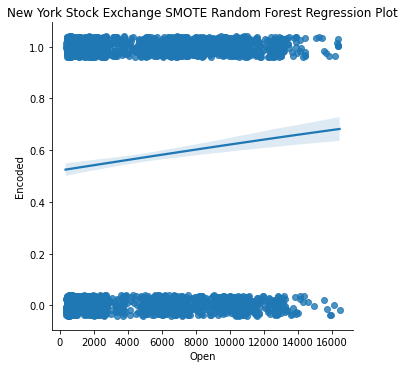

In [104]:
SRFC_reg_plot = sns.lmplot(x="Open", y="Encoded", data=SRFC_plot_df,
           logistic=True, y_jitter=.04);
SRFC_reg_plot.set(title = 'New York Stock Exchange SMOTE Random Forest Regression Plot')

In [105]:
SRFC_reg_plot.savefig('Plots/plots_2/NYA_SMOTE_Random_Forest_Regression_2.png')

In [106]:
# Display the confusion matrix
#from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, y_pred)

array([[1349,  278],
       [ 160, 1700]])

In [107]:
# Print the imbalanced classification report
#from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Down       0.89      0.83      0.91      0.86      0.87      0.75      1627
         Up       0.86      0.91      0.83      0.89      0.87      0.76      1860

avg / total       0.88      0.87      0.87      0.87      0.87      0.76      3487



### undersampling

In [108]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({'Down': 4879, 'Up': 4879})

In [109]:
# Train the Logistic Regression model using the resampled data
#from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [110]:
# Calculated the balanced accuracy score
#from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.8710653885044709

In [111]:
# Display the confusion matrix
#from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, y_pred)

array([[1441,  186],
       [ 267, 1593]])

In [112]:
# create an acutal and predicted df
URFC_pred_df = pd.DataFrame({"Prediction": y_pred, "Actual": y_test})
URFC_pred_df.head()

,Prediction,Actual
5403,Up,Up
1746,Down,Down
8985,Down,Down
4186,Up,Up
13791,Down,Down


In [113]:
# merge test predictions with intitial df for comparison
URFC_df = URFC_pred_df.merge(df_NYA, left_index=True, right_index=True)
URFC_df = URFC_df[['Region', 'Exchange', 'Index', 'Currency',
       'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'CloseUSD', 'PrevClose', 'PrevHigh', 'PrevLow', 'Delta', 'Target', 'Actual','Prediction']]
URFC_df.drop('Target', axis=1, inplace=True)
URFC_df['Date'] =  pd.to_datetime(URFC_df['Date'])
URFC_df.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Actual,Prediction
5403,United States,New York Stock Exchange,NYA,USD,1987-07-07,1828.089966,1828.089966,1828.089966,1828.089966,1828.089966,0.000000e+00,1828.089966,1813.920044,1813.920044,1813.920044,14.169922,Up,Up
1746,United States,New York Stock Exchange,NYA,USD,1973-01-15,681.159973,681.159973,681.159973,681.159973,681.159973,0.000000e+00,681.159973,686.760010,686.760010,686.760010,-5.600037,Down,Down
8985,United States,New York Stock Exchange,NYA,USD,2001-09-07,5986.529785,5986.529785,5986.529785,5986.529785,5986.529785,1.424300e+09,5986.529785,6104.319824,6104.319824,6104.319824,-117.790039,Down,Down
4186,United States,New York Stock Exchange,NYA,USD,1982-09-13,740.479980,740.479980,740.479980,740.479980,740.479980,0.000000e+00,740.479980,733.919983,733.919983,733.919983,6.559997,Up,Up
13791,United States,New York Stock Exchange,NYA,USD,2020-10-15,12974.129880,13148.700200,12960.980470,13137.250000,13137.250000,3.717640e+09,13137.250000,13143.160160,13267.160160,13135.900390,-5.910160,Down,Down


In [114]:
# export as csv
URFC_df.to_csv('Data/data_2/Undersampling_Random_Forest_Predictions_2.csv')

In [115]:
URFC_plot_df = URFC_df
URFC_plot_df['Encoded'] = URFC_plot_df['Prediction'].map({'Up':1, 'Down':0})
URFC_plot_df.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Actual,Prediction,Encoded
5403,United States,New York Stock Exchange,NYA,USD,1987-07-07,1828.089966,1828.089966,1828.089966,1828.089966,1828.089966,0.000000e+00,1828.089966,1813.920044,1813.920044,1813.920044,14.169922,Up,Up,1
1746,United States,New York Stock Exchange,NYA,USD,1973-01-15,681.159973,681.159973,681.159973,681.159973,681.159973,0.000000e+00,681.159973,686.760010,686.760010,686.760010,-5.600037,Down,Down,0
8985,United States,New York Stock Exchange,NYA,USD,2001-09-07,5986.529785,5986.529785,5986.529785,5986.529785,5986.529785,1.424300e+09,5986.529785,6104.319824,6104.319824,6104.319824,-117.790039,Down,Down,0
4186,United States,New York Stock Exchange,NYA,USD,1982-09-13,740.479980,740.479980,740.479980,740.479980,740.479980,0.000000e+00,740.479980,733.919983,733.919983,733.919983,6.559997,Up,Up,1
13791,United States,New York Stock Exchange,NYA,USD,2020-10-15,12974.129880,13148.700200,12960.980470,13137.250000,13137.250000,3.717640e+09,13137.250000,13143.160160,13267.160160,13135.900390,-5.910160,Down,Down,0


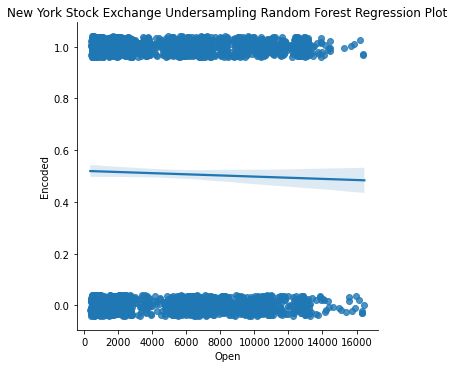

In [116]:
URFC_reg_plot = sns.lmplot(x="Open", y="Encoded", data=URFC_plot_df,
           logistic=True, y_jitter=.04);
URFC_reg_plot.set(title = 'New York Stock Exchange Undersampling Random Forest Regression Plot')

In [117]:
SRFC_reg_plot.savefig('Plots/plots_2/NYA_Undersampling_Random_Forest_Regression_2.png')

In [118]:
# Print the imbalanced classification report
#from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Down       0.84      0.89      0.86      0.86      0.87      0.76      1627
         Up       0.90      0.86      0.89      0.88      0.87      0.76      1860

avg / total       0.87      0.87      0.87      0.87      0.87      0.76      3487



### decision tree model

In [119]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [120]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [121]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [122]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

In [123]:
# Fitting the model
model = model.fit(X_train_scaled, y_train)

In [124]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [125]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [126]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1200,427
Actual 1,417,1443


Accuracy Score : 0.7579581301978778
Classification Report
              precision    recall  f1-score   support

        Down       0.74      0.74      0.74      1627
          Up       0.77      0.78      0.77      1860

    accuracy                           0.76      3487
   macro avg       0.76      0.76      0.76      3487
weighted avg       0.76      0.76      0.76      3487

